<h1>I. First Method : "Automatic Cardiac Disease Assessment on cine-MRI via Time-Series Segmentation and Domain Specific Features"</h1>


<h2>1. Pre-processing</h2>
<p>In this section, we will load the data and perform pre-processing steps such as normalization and resizing.</p>


In [19]:
#importing all librairies for the random forest classifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import nibabel as nib
import os
from scipy.ndimage import binary_fill_holes, label
from skimage.segmentation import flood
from skimage import measure, morphology
import cv2
from scipy import ndimage
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone


In [3]:
path='./data/Dataset/'
test_metadata= pd.read_csv(path+'metaDataTest.csv')
train_metadata = pd.read_csv(path+'metaDataTrain.csv')
SampleSubmission = pd.read_csv(path+'SampleSubmission.csv')

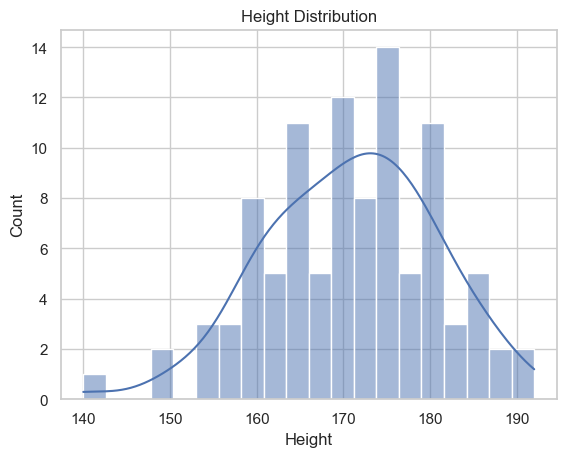

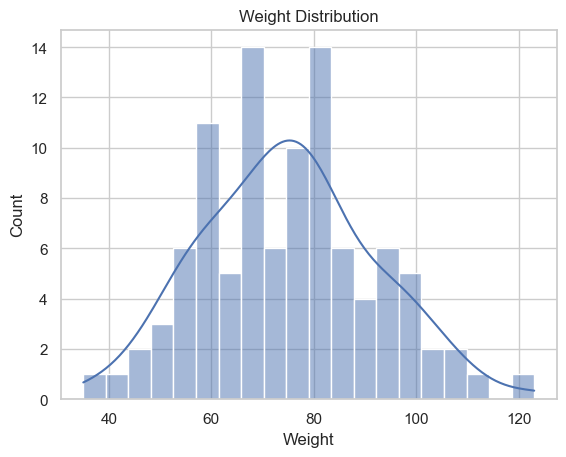

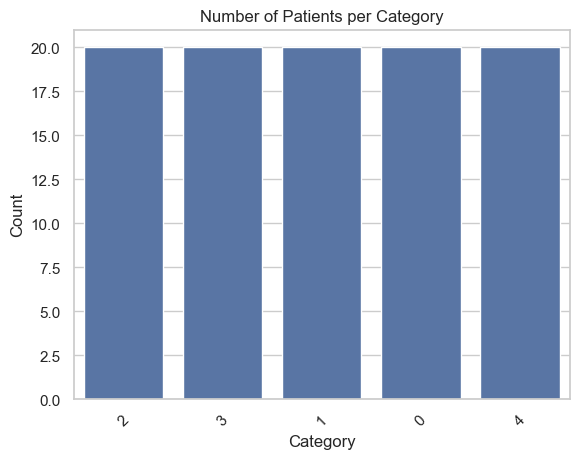

In [ ]:
#visualizing the metadata and the distribution


sns.set(style="whitegrid")

#Plot Height distribution
plt.figure()
sns.histplot(train_metadata['Height'], bins=20, kde=True)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

#Plot Weight distribution
plt.figure()
sns.histplot(train_metadata['Weight'], bins=20, kde=True)
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

#Plot number of patients per Category
plt.figure()
sns.countplot(x='Category', data=train_metadata, order=train_metadata['Category'].value_counts().index)
plt.title('Number of Patients per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

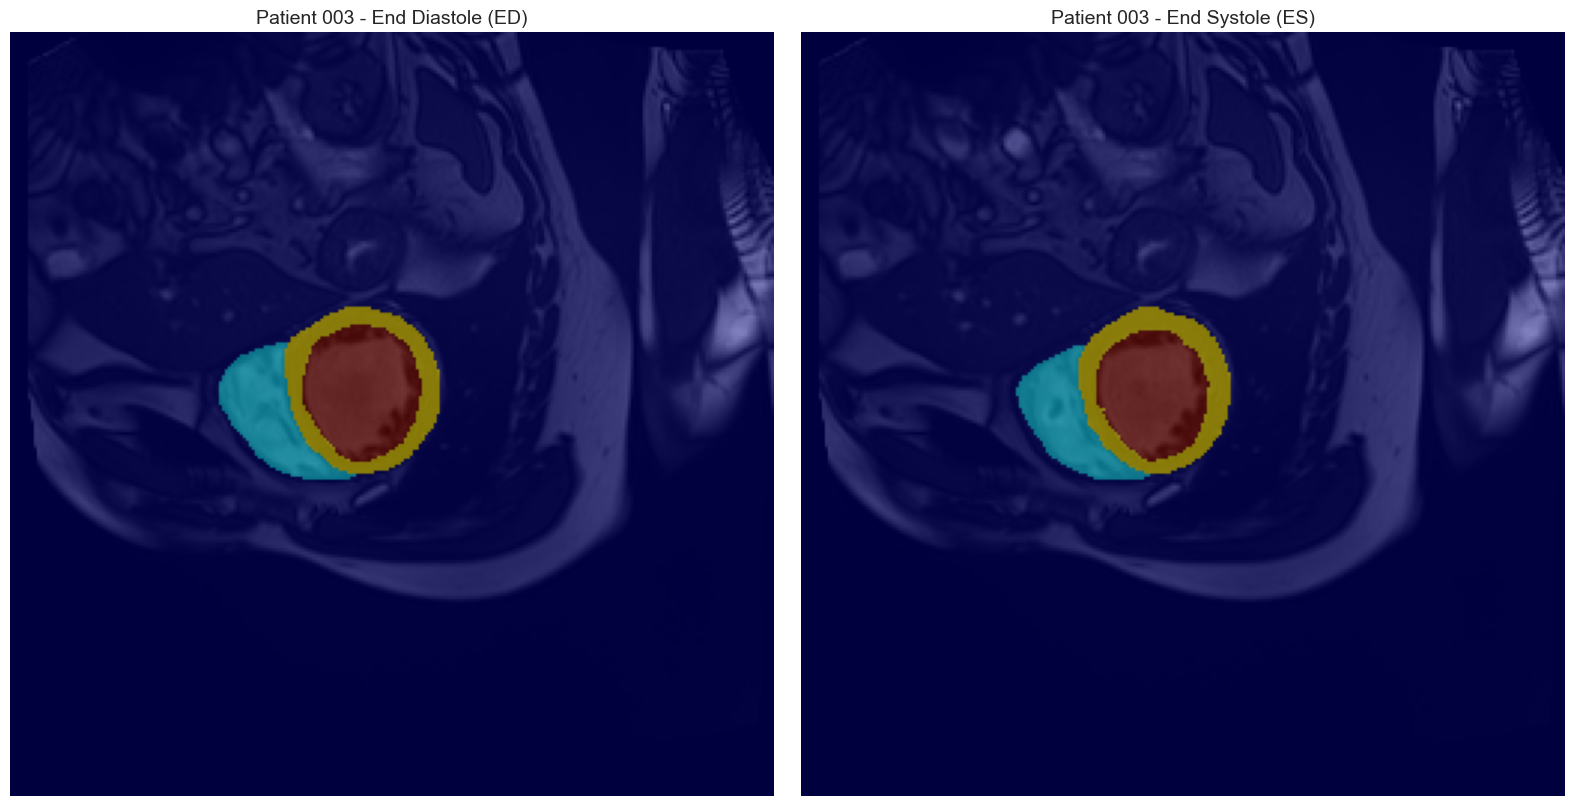

In [ ]:
#visualizing the segmentations

path_train = path + 'Train/'
path_test = path + 'Test/'
patient_id = '003'

image_ED = nib.load(path_train + patient_id + '/' + patient_id + '_ED.nii').get_fdata()
seg_ED = nib.load(path_train + patient_id + '/' + patient_id + '_ED_seg.nii').get_fdata()
image_ES = nib.load(path_train + patient_id + '/' + patient_id + '_ES.nii').get_fdata()
seg_ES = nib.load(path_train + patient_id + '/' + patient_id + '_ES_seg.nii').get_fdata()

slice_idx = image_ED.shape[2] // 2  # Middle slice



fig, axes = plt.subplots(1, 2, figsize=(16, 8))


axes[0].imshow(image_ED[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].imshow(seg_ED[:, :, slice_idx].T, cmap='jet', alpha=0.5, origin='lower')
axes[0].set_title(f'Patient {patient_id} - End Diastole (ED)', fontsize=14)
axes[0].axis('off')
axes[1].imshow(image_ES[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1].imshow(seg_ES[:, :, slice_idx].T, cmap='jet', alpha=0.5, origin='lower')
axes[1].set_title(f'Patient {patient_id} - End Systole (ES)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
'''functions that will be used to compute the volumes of the segments and the ejection fraction, which are the features of the model'''

def compute_volumes(segmentation_nii_path):
    seg = nib.load(segmentation_nii_path)
    data = seg.get_fdata()
    header = seg.header
    voxel_volume = np.prod(header.get_zooms())  # mm³ per voxel

    # Labels
    RV_volume = np.sum(data == 1) * voxel_volume / 1_000_000  # in liters
    Myo_volume = np.sum(data == 2) * voxel_volume / 1_000_000  # in liters
    LV_volume = np.sum(data == 3) * voxel_volume / 1_000_000  # in liters

    return LV_volume, RV_volume, Myo_volume

def compute_ejection_fraction(volume_ED, volume_ES):
    return (volume_ED - volume_ES) / volume_ED * 100

def compute_ratios(LV_vol, RV_vol, Myo_vol):
    ratio_RV_LV = RV_vol / LV_vol if LV_vol > 0 else 0
    ratio_Myo_LV = Myo_vol / LV_vol if LV_vol > 0 else 0
    return ratio_RV_LV, ratio_Myo_LV

In [ ]:
'''this is the function we use to reconstruct the missing LV inside the myocardium by filling holes slice by slice.'''

def reconstruct_lv_from_myo_fill(mri_segmentation):
    """
    Reconstruct the missing LV inside myocardium by filling holes slice by slice.

    Args:
        mri_segmentation (np.ndarray): 3D segmentation volume (labels 1,2,...)

    Returns:
        np.ndarray: corrected segmentation with LV (label 3) reconstructed.
    """
    corrected_segmentation = mri_segmentation.copy()

    # Work on End-Diastole
    for idx in range(corrected_segmentation.shape[2]):
        seg_slice = corrected_segmentation[:, :, idx]

        # Extract myocardium mask (label == 2)
        myo_mask = (seg_slice == 2).astype(np.uint8)

        if np.count_nonzero(myo_mask) == 0:
            continue

        # Fill holes inside myocardium
        filled = ndimage.binary_fill_holes(myo_mask).astype(np.uint8)

        # LV = filled - myocardium
        lv_mask = filled & (~myo_mask)

        # Update segmentation: set LV label to 3
        corrected_segmentation[:, :, idx][lv_mask == 1] = 3

    return corrected_segmentation

In [ ]:
'''In this cell we store the features for each patients building a dataframe that will be used to train the model.'''

# Storage
features_list_train = []

# Loop over all patients
for idx, row in train_metadata.iterrows():
    patient_id = str(int(row['Id'])).zfill(3)

    weight = row['Weight']
    height = row['Height']
    category = row['Category']

    seg_ED_path = os.path.join(path_train, patient_id, f'{patient_id}_ED_seg.nii')
    seg_ES_path = os.path.join(path_train, patient_id, f'{patient_id}_ES_seg.nii')

    seg_ED = nib.load(seg_ED_path)
    seg_ES = nib.load(seg_ES_path)

    data_ED = seg_ED.get_fdata()
    data_ES = seg_ES.get_fdata()

    voxel_volume = np.prod(seg_ED.header.get_zooms())  # Same for ED and ES

    # Fix segmentation: reconstruct LV from filled myocardium
    corrected_seg_ED = reconstruct_lv_from_myo_fill(data_ED)
    corrected_seg_ES = reconstruct_lv_from_myo_fill(data_ES)

        # Compute volumes
    LV_ED = np.sum(corrected_seg_ED == 3) * voxel_volume
    RV_ED = np.sum(corrected_seg_ED == 1) * voxel_volume 
    Myo_ED = np.sum(corrected_seg_ED == 2) * voxel_volume 

    LV_ES = np.sum(corrected_seg_ES == 3) * voxel_volume 
    RV_ES = np.sum(corrected_seg_ES == 1) * voxel_volume 
    Myo_ES = np.sum(corrected_seg_ES == 2) * voxel_volume 

    # Compute EF
    LV_EF = ((LV_ED - LV_ES) / LV_ED) * 100 if LV_ED != 0 else 0
    RV_EF = ((RV_ED - RV_ES) / RV_ED) * 100 if RV_ED != 0 else 0

    # Compute Ratios
    RV_LV_ratio_ED = RV_ED / LV_ED if LV_ED != 0 else 0
    RV_LV_ratio_ES = RV_ES / LV_ES if LV_ES != 0 else 0
    Myo_LV_ratio_ED = Myo_ED / LV_ED if LV_ED != 0 else 0
    Myo_LV_ratio_ES = Myo_ES / LV_ES if LV_ES != 0 else 0

    # Gather features
    features = {
        'Id': patient_id,
        'Weight': weight,
        'Height': height,
        'LV_ED_volume': LV_ED,
        'LV_ES_volume': LV_ES,
        'RV_ED_volume': RV_ED,
        'RV_ES_volume': RV_ES,
        'Myo_ED_volume': Myo_ED,
        'Myo_ES_volume': Myo_ES,
        'LV_EF': LV_EF,
        'RV_EF': RV_EF,
        'RV_LV_ratio_ED': RV_LV_ratio_ED,
        'RV_LV_ratio_ES': RV_LV_ratio_ES,
        'Myo_LV_ratio_ED': Myo_LV_ratio_ED,
        'Myo_LV_ratio_ES': Myo_LV_ratio_ES,
        'Category': category
    }

    features_list_train.append(features)

train_features_df = pd.DataFrame(features_list_train)
train_features_df.head()


,Id,Weight,Height,LV_ED_volume,LV_ES_volume,RV_ED_volume,RV_ES_volume,Myo_ED_volume,Myo_ES_volume,LV_EF,RV_EF,RV_LV_ratio_ED,RV_LV_ratio_ES,Myo_LV_ratio_ED,Myo_LV_ratio_ES,Category
0,001,95.0,184.0,295507.812500,225610.351562,139721.679688,59545.898438,164257.812500,195068.359375,23.653338,57.382492,0.472819,0.263932,0.555849,0.864625,2.0
1,002,70.0,160.0,265744.400024,188303.375244,94432.067871,28823.089600,160433.578491,192565.155029,29.141169,69.477435,0.355349,0.153067,0.603714,1.022633,2.0
2,003,77.0,165.0,276708.984375,241088.867188,192333.984375,174584.960938,191845.703125,201074.218750,12.872772,9.228231,0.695077,0.724152,0.693312,0.834025,2.0
3,004,46.0,159.0,260847.091675,226472.473145,106264.114380,84543.991089,168452.453613,174957.275391,13.178072,20.439754,0.407381,0.373308,0.645790,0.772532,2.0
4,005,77.0,165.0,290797.119141,224094.726562,170463.867188,74553.222656,201392.578125,232261.962891,22.937776,56.264501,0.586195,0.332686,0.692554,1.036445,2.0


In [9]:
# Feature extraction for the testing set
test_features_list = []

for idx, row in test_metadata.iterrows():
    patient_id = str(int(row['Id']))  # no zfill(3)

    try:
        # Patient features
        weight = row['Weight']
        height = row['Height']

        # Load segmentations
        seg_ED_path = os.path.join(path_test, patient_id, f'{patient_id}_ED_seg.nii')
        seg_ES_path = os.path.join(path_test, patient_id, f'{patient_id}_ES_seg.nii')

        seg_ED = nib.load(seg_ED_path)
        seg_ES = nib.load(seg_ES_path)

        data_ED = seg_ED.get_fdata()
        data_ES = seg_ES.get_fdata()

        voxel_volume = np.prod(seg_ED.header.get_zooms())

        # Fix segmentation: reconstruct LV from filled myocardium
        corrected_seg_ED = reconstruct_lv_from_myo_fill(data_ED)
        corrected_seg_ES = reconstruct_lv_from_myo_fill(data_ES)

        # Compute volumes
        LV_ED = np.sum(corrected_seg_ED == 3) * voxel_volume
        RV_ED = np.sum(corrected_seg_ED == 1) * voxel_volume 
        Myo_ED = np.sum(corrected_seg_ED == 2) * voxel_volume 

        LV_ES = np.sum(corrected_seg_ES == 3) * voxel_volume 
        RV_ES = np.sum(corrected_seg_ES == 1) * voxel_volume 
        Myo_ES = np.sum(corrected_seg_ES == 2) * voxel_volume 

        # Compute ejection fractions
        if LV_ED > 0 and LV_ES > 0:
            if LV_ED > LV_ES:
                LV_EF = ((LV_ED - LV_ES) / LV_ED) * 100
            else:
                LV_EF = 0  # Physically impossible, better to set to 0
        else:
            LV_EF = 0

        RV_EF = ((RV_ED - RV_ES) / RV_ED) * 100 if RV_ED != 0 else 0

        # Compute ratios
        RV_LV_ratio_ED = RV_ED / LV_ED if LV_ED != 0 else 0
        RV_LV_ratio_ES = RV_ES / LV_ES if LV_ES != 0 else 0
        Myo_LV_ratio_ED = Myo_ED / LV_ED if LV_ED != 0 else 0
        Myo_LV_ratio_ES = Myo_ES / LV_ES if LV_ES != 0 else 0

        # Gather features
        features = {
            'Id': patient_id,
            'Weight': weight,
            'Height': height,
            'LV_ED_volume': LV_ED,
            'LV_ES_volume': LV_ES,
            'RV_ED_volume': RV_ED,
            'RV_ES_volume': RV_ES,
            'Myo_ED_volume': Myo_ED,
            'Myo_ES_volume': Myo_ES,
            'LV_EF': LV_EF,
            'RV_EF': RV_EF,
            'RV_LV_ratio_ED': RV_LV_ratio_ED,
            'RV_LV_ratio_ES': RV_LV_ratio_ES,
            'Myo_LV_ratio_ED': Myo_LV_ratio_ED,
            'Myo_LV_ratio_ES': Myo_LV_ratio_ES
        }

        test_features_list.append(features)

    except FileNotFoundError as e:
        print(f"Skipping patient {patient_id}: missing file.")

# Create the test features DataFrame
test_features_df = pd.DataFrame(test_features_list)

# Check results
test_features_df.head()

#save both features dataframes in the challenge folder
# Save the features DataFrames to CSV files
train_features_df.to_csv(path+'train_features.csv', index=False)
test_features_df.to_csv(path+'test_features.csv', index=False)




Patient 114


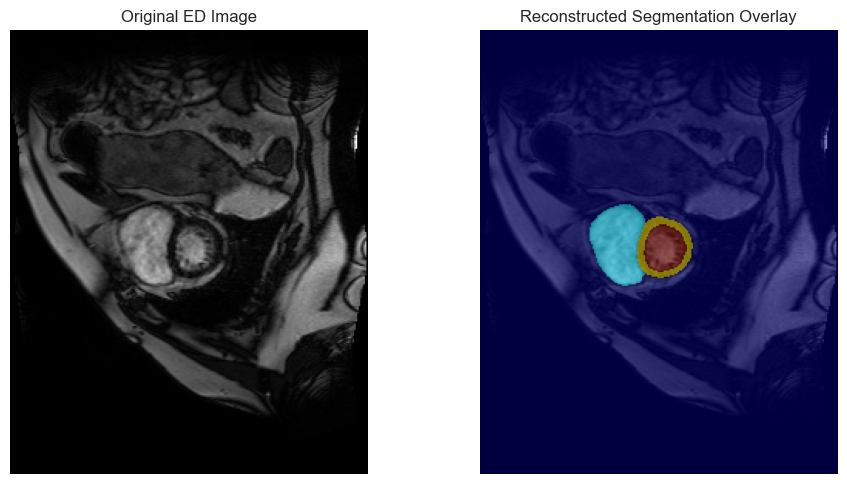


Patient 140


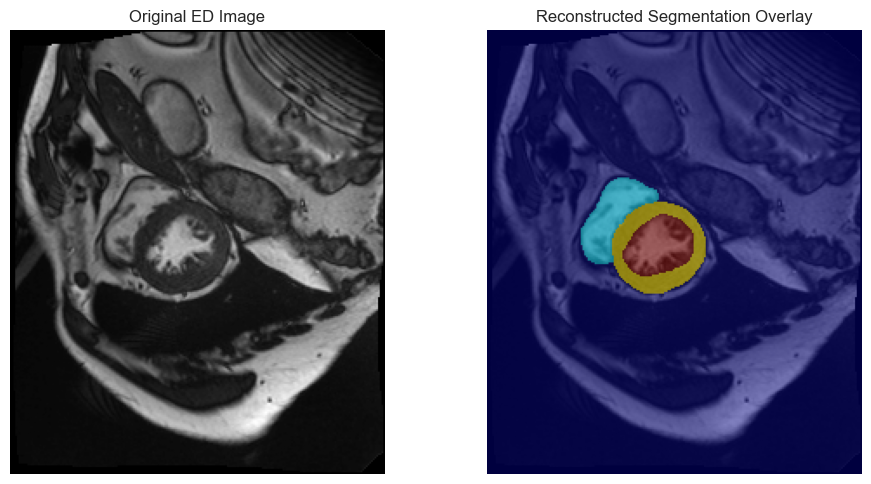


Patient 131


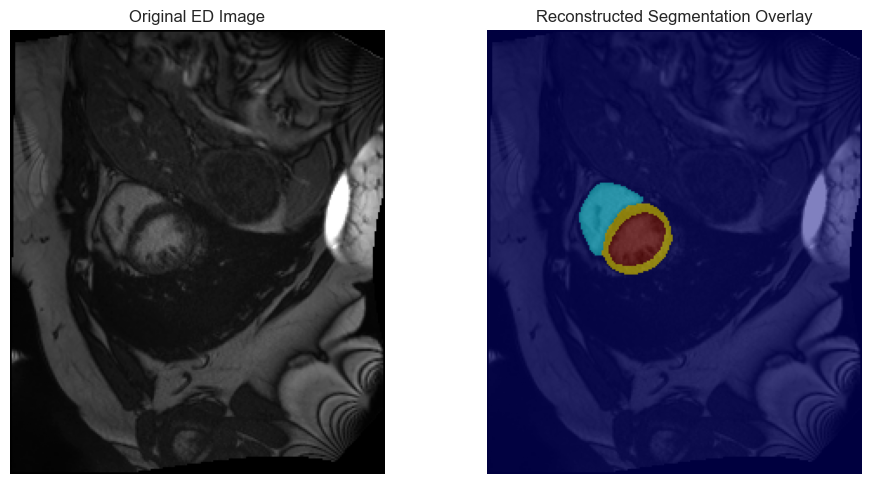


Patient 146


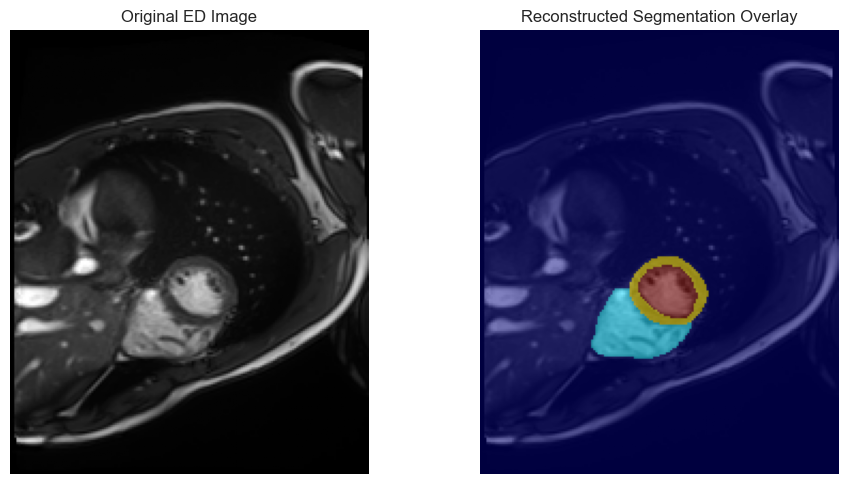


Patient 118


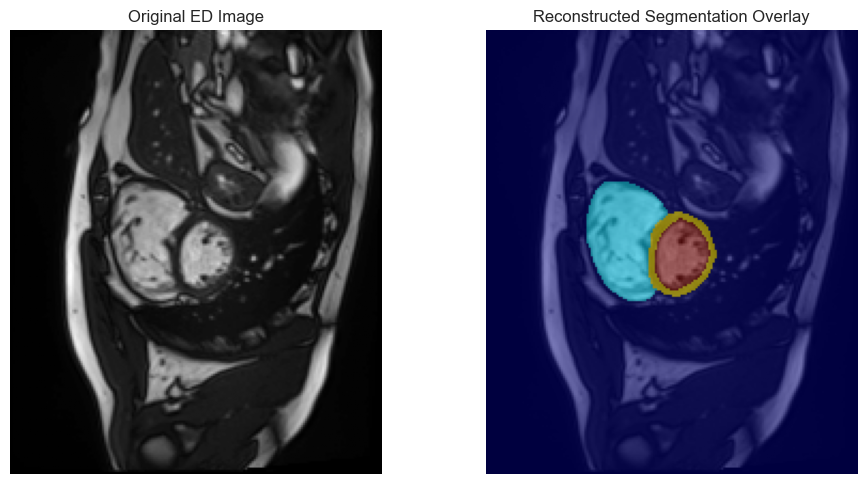

In [ ]:
'''in order to make sure the reconstruction of the LV is correct, we will visualize the results on 5 random patients.'''

def plot_reconstruction(image_ED, corrected_seg_ED, slice_idx=None):
    """
    Visualize the ED image and the corrected segmentation overlay.
    """
    if slice_idx is None:
        slice_idx = image_ED.shape[2] // 2  # Default: middle slice

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_ED[:, :, slice_idx].T, cmap='gray', origin='lower')
    plt.title('Original ED Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_ED[:, :, slice_idx].T, cmap='gray', origin='lower')
    plt.imshow(corrected_seg_ED[:, :, slice_idx].T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('Reconstructed Segmentation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test visualization on 5 random patients
sample_patients = test_metadata.sample(5, random_state=42)  # random_state to fix randomness

for idx, row in sample_patients.iterrows():
    patient_id = str(int(row['Id']))  # no zfill(3)

    print(f"\nPatient {patient_id}")

    try:
        # Load paths
        seg_ED_path = os.path.join(path_test, patient_id, f'{patient_id}_ED_seg.nii')
        img_ED_path = os.path.join(path_test, patient_id, f'{patient_id}_ED.nii')

        seg_ED = nib.load(seg_ED_path)
        img_ED = nib.load(img_ED_path)

        data_ED = seg_ED.get_fdata()
        image_ED = img_ED.get_fdata()

        # Reconstruct LV cavity
        corrected_seg_ED = reconstruct_lv_from_myo_fill(data_ED)  # <<< CORRECT here: only segmentation needed

        # Plot result
        plot_reconstruction(image_ED, corrected_seg_ED)

    except FileNotFoundError as e:
        print(f"Skipping patient {patient_id}: missing files.")


In [ ]:
'''we add additional features to enrich the dataset. The BSA (Body Surface Area) is computed from the weight and height of the patients. It is then used to normalize the volumes of the segments. It helps to make the model more robust to variations in body size.'''
def compute_bsa(weight, height):
    return 0.007184 * (weight ** 0.425) * (height ** 0.725)

train_features_df['BSA'] = compute_bsa(train_features_df['Weight'], train_features_df['Height'])
test_features_df['BSA'] = compute_bsa(test_features_df['Weight'], test_features_df['Height'])

# Normalizing using BSA
volume_cols = [
    'LV_ED_volume', 'LV_ES_volume',
    'RV_ED_volume', 'RV_ES_volume',
    'Myo_ED_volume', 'Myo_ES_volume'
]

for col in volume_cols:
    train_features_df[col] = train_features_df[col] / train_features_df['BSA']
    test_features_df[col] = test_features_df[col] / test_features_df['BSA']

#No need to use it as a feature so we get rid of it
train_features_df = train_features_df.drop(columns=['BSA'])
test_features_df = test_features_df.drop(columns=['BSA'])

In [ ]:
# adding new relevant features since the score isn't improving with the current ones
def add_new_features(df):
    df = df.copy()
    
    # 1. ΔVolume VG (diastole - systole)
    df['LV_volume_delta'] = df['LV_ED_volume'] - df['LV_ES_volume']
    
    # 2. ΔVolume VD (diastole - systole)
    df['RV_volume_delta'] = df['RV_ED_volume'] - df['RV_ES_volume']
    
    # 3. Moyenne des fractions d'éjection
    df['Mean_EF'] = (df['LV_EF'] + df['RV_EF']) / 2
    
    # 4. Ratio Myocarde / VG en diastole
    df['Myo_LV_volume_ratio'] = df['Myo_ED_volume'] / df['LV_ED_volume']
    
    # 5. Volume total ED (somme VG + VD + Myocarde en diastole)
    df['Total_ED_volume'] = df['LV_ED_volume'] + df['RV_ED_volume'] + df['Myo_ED_volume']
    
    return df

train_features_df = add_new_features(train_features_df)
test_features_df = add_new_features(test_features_df)

X_train = train_features_df.drop(columns=['Id', 'Category'])
y_train = train_features_df['Category']

X_test = test_features_df.drop(columns=['Id'])


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best cross-validation accuracy: 0.95
Best hyperparameters: {'n_estimators': np.int64(500), 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': np.int64(27)}

Fold 1

Fold 2

Fold 3

Fold 4

Fold 5

Mean metrics per class:
Class 0.0: precision: 0.920, recall: 1.000, f1-score: 0.956
Class 1.0: precision: 0.920, recall: 0.950, f1-score: 0.927
Class 2.0: precision: 0.960, recall: 0.900, f1-score: 0.921
Class 3.0: precision: 1.000, recall: 0.950, f1-score: 0.971
Class 4.0: precision: 1.000, recall: 0.950, f1-score: 0.971


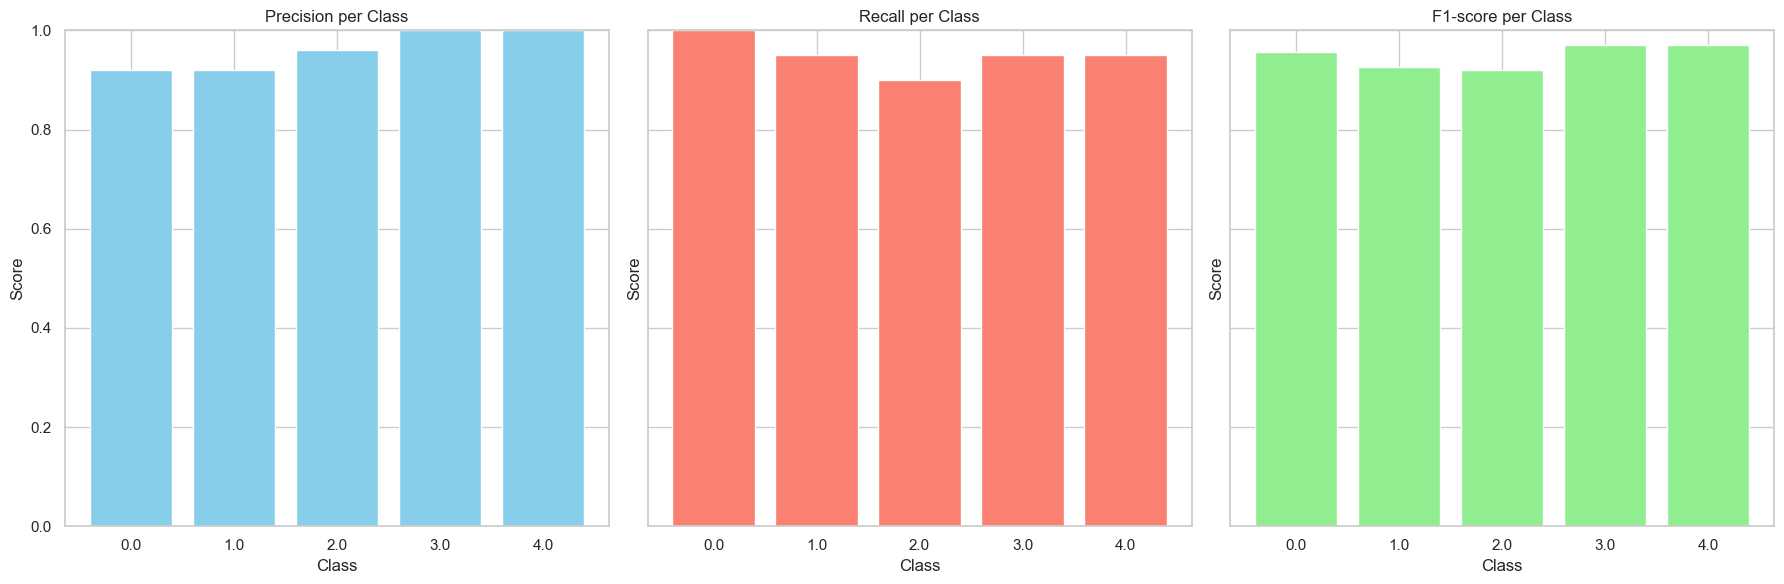


Final 5-fold accuracy scores: [0.95 0.95 0.95 0.95 0.95]
Final mean accuracy: 0.95


RandomForestClassifier(class_weight='balanced', max_depth=np.int64(27),
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=np.int64(500), random_state=42)

In [21]:
#defining the model and the hyperparameters to be optimized
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

param_dist = {
    'n_estimators': np.arange(300, 800, 50),
    'max_depth': np.arange(15, 30, 2),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#searching for the best hyperparameters using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best cross-validation accuracy:", round(random_search.best_score_, 4))
print("Best hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
#in order to evaulate the model but also understand which classes the model is struggling with, we will use the StratifiedKFold to split the data into 5 folds and evaluate the model on each fold.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
class_scores = {}

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"\nFold {fold_idx + 1}")
    
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    clf = clone(best_rf)
    clf.fit(X_fold_train, y_fold_train)
    y_pred = clf.predict(X_fold_test)
    
    report = classification_report(y_fold_test, y_pred, output_dict=True)
    for class_label, metrics in report.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(metrics, dict):
            if class_label not in class_scores:
                class_scores[class_label] = {'precision': [], 'recall': [], 'f1-score': []}
            for metric in ['precision', 'recall', 'f1-score']:
                class_scores[class_label][metric].append(metrics[metric])

#metrics per class
mean_scores = {
    class_label: {
        metric: np.mean(values)
        for metric, values in metrics.items()
    }
    for class_label, metrics in class_scores.items()
}

print("\nMean metrics per class:")
for class_label, metrics in mean_scores.items():
    print(f"Class {class_label}: " + ", ".join(f"{k}: {v:.3f}" for k, v in metrics.items()))

#visualizing results
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
metrics = ['precision', 'recall', 'f1-score']
colors = ['skyblue', 'salmon', 'lightgreen']

for i, metric in enumerate(metrics):
    ax[i].bar(
        mean_scores.keys(),
        [mean_scores[c][metric] for c in mean_scores.keys()],
        color=colors[i]
    )
    ax[i].set_title(f'{metric.capitalize()} per Class')
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Score')
    ax[i].set_ylim(0, 1)

plt.tight_layout()
plt.savefig("classification_metrics_per_class.png", dpi=300)
plt.show()

#final evaluation of the training set using cross-validation
final_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv)
print("\nFinal 5-fold accuracy scores:", final_cv_scores)
print("Final mean accuracy:", round(final_cv_scores.mean(), 4))

# retraining the model on all the data
best_rf.fit(X_train, y_train)


In [22]:
#prediction on the test set
test_predictions = best_rf.predict(X_test)
submission = pd.DataFrame({
    'Id': test_features_df['Id'],
    'Category': test_predictions
})
submission.to_csv('submission_finalfinal.csv', index=False)
submission.head()


,Id,Category
0,101,3.0
1,102,4.0
2,103,3.0
3,104,0.0
4,105,2.0
